In [1]:
# Data management
# ------------------------------------------------------------------------------
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd

# Graphics
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing and modelling
# evaluate bagging ensemble for regression
# ------------------------------------------------------------------------------
#from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

from sklearn import metrics
from sklearn.metrics import mean_squared_error


import lightgbm





# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
#warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

In [2]:
# Data Loading


#training data
data_train = pd.read_csv('https://raw.githubusercontent.com/SantiagoArenas/MachineLearning/main/austinHousingData.csv')
data_train.head()
data_train=data_train[data_train['latestPrice'] < 2000000].copy()



In [3]:
# Columnas descartables de inicio
data_train = data_train.drop(["description","homeImage","zpid","streetAddress","latest_saledate","latestPriceSource", 'garageSpaces'], axis=1)
#Cogemos los datos que queremos
data_train = data_train[data_train['city'] == 'austin']
data_train = data_train[data_train['homeType'] == 'Single Family']
#Tiene los mismos valores siempre, entonces no aporta nada
data_train = data_train.drop(["city","homeType"], axis=1)

In [4]:
numeric_cols = data_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = data_train.select_dtypes(include=['object', 'category', 'bool']).columns.to_list()

In [5]:
#Prefijos para las dummies
new_column_names = [
    'Dmy_association',
    'Dmy_cooling',
    'Dmy_garage',
    'Dmy_heating',
    'Dmy_spa',
    'Dmy_view'
]
data=pd.get_dummies(data_train, columns=cat_cols, prefix=new_column_names,drop_first=True, dtype= 'int64' ) 
print(data.dtypes)

zipcode                         int64
latitude                      float64
longitude                     float64
propertyTaxRate               float64
parkingSpaces                   int64
yearBuilt                       int64
latestPrice                   float64
numPriceChanges                 int64
latest_salemonth                int64
latest_saleyear                 int64
numOfPhotos                     int64
numOfAccessibilityFeatures      int64
numOfAppliances                 int64
numOfParkingFeatures            int64
numOfPatioAndPorchFeatures      int64
numOfSecurityFeatures           int64
numOfWaterfrontFeatures         int64
numOfWindowFeatures             int64
numOfCommunityFeatures          int64
lotSizeSqFt                   float64
livingAreaSqFt                float64
numOfPrimarySchools             int64
numOfElementarySchools          int64
numOfMiddleSchools              int64
numOfHighSchools                int64
avgSchoolDistance             float64
avgSchoolRat

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13916 entries, 17 to 15170
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zipcode                     13916 non-null  int64  
 1   latitude                    13916 non-null  float64
 2   longitude                   13916 non-null  float64
 3   propertyTaxRate             13916 non-null  float64
 4   hasAssociation              13916 non-null  bool   
 5   hasCooling                  13916 non-null  bool   
 6   hasGarage                   13916 non-null  bool   
 7   hasHeating                  13916 non-null  bool   
 8   hasSpa                      13916 non-null  bool   
 9   hasView                     13916 non-null  bool   
 10  parkingSpaces               13916 non-null  int64  
 11  yearBuilt                   13916 non-null  int64  
 12  latestPrice                 13916 non-null  float64
 13  numPriceChanges             13

In [7]:
# Configuring train and test datasets
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        data.drop(columns = "latestPrice"),
                                        data['latestPrice'],
                                        random_state = 123,
                                        test_size=0.2
                                    )


In [8]:
# Model ussing Gradient Boosting

# - Does not binning
# - Uses a single core (does not parallelize any part of the algorithm)
# - Allows working on sparse matrices
# - Necessary to do one-hot-encoding of categorical variables

In [9]:
# Simple Model creation
# ==============================================================================
model = GradientBoostingRegressor(
            n_estimators = 15,
            loss         = 'squared_error',
            max_features = 'sqrt',
            random_state = 123
         )

# Model trainingEntrenamiento del modelo
# ==============================================================================
model.fit(X_train, y_train)

GradientBoostingRegressor(max_features='sqrt', n_estimators=15,
                          random_state=123)

In [10]:
# Model training error
#-------------------------------------------------------------------------------
prediction_train = model.predict(X = X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = prediction_train,
        squared = False
       )
print(f"RMSE in train: {rmse}")

R2 Value in training: 0.51
Accuracy in training 62.85
RMSE in train: 194905.38680147976


In [11]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = model.predict(X = X_test)


#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))
      
 
residuals_testn=y_test - prediction_test

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = prediction_test,
        squared = False
       )
print(f"RMSE in test: {rmse}")

Accuracy in test 58.15
RMSE in test: 193847.4467964935


Optimum value for n_estimators: 476


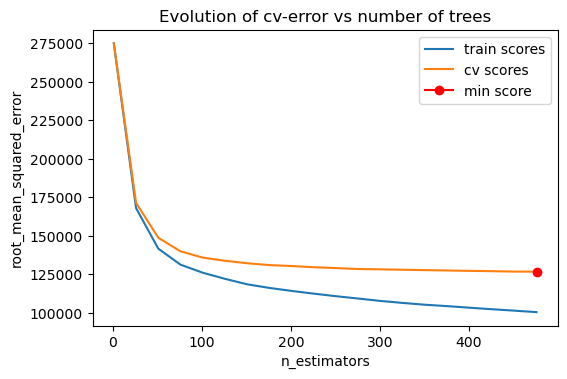

In [12]:
# the number of trees is searched based on k-cross-validation & neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 500, 25)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = GradientBoostingRegressor(
                n_estimators = n_estimators,
                loss         = 'squared_error',
                max_features = 'sqrt',
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1,
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolution of cv-error vs number of trees")
plt.legend();
print(f"Optimum value for n_estimators: {estimator_range[np.argmin(cv_scores)]}")

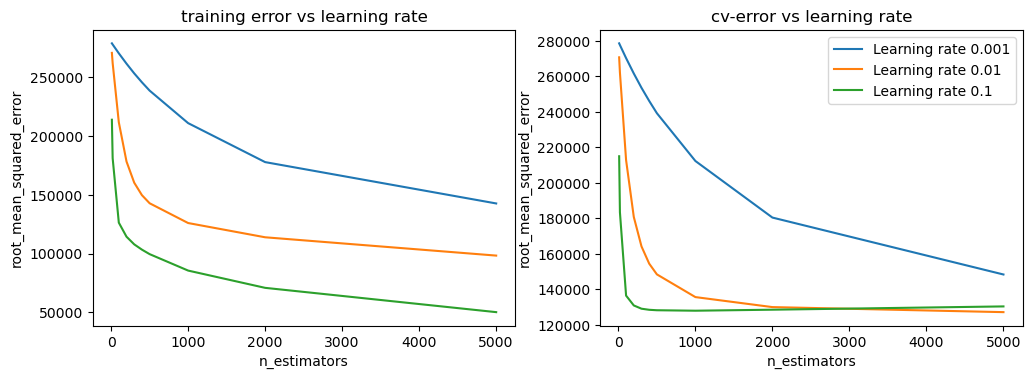

In [13]:
# Learning rate is tested based on k-cross-validation & neg_root_mean_squared_error
# ==============================================================================
results = {}

# Values tested
learning_rates = [0.001, 0.01, 0.1]
n_estimators   = [10, 20, 100, 200, 300, 400, 500, 1000, 2000, 5000]


# Loop for trining the model trying combinations of  learning_rate & n_estimator 
# Obtaining training error & k-cross-validation error.
for learning_rate in learning_rates:
    train_scores = []
    cv_scores    = []
    
    for n_estimator in n_estimators:
    
        model = GradientBoostingRegressor(
                    n_estimators  = n_estimator,
                    learning_rate = learning_rate,
                    loss          = 'squared_error',
                    max_features  = 'sqrt',
                    random_state  = 123
                 )

        # Error de train
        model.fit(X_train, y_train)
        predictions = model.predict(X = X_train)
        rmse = mean_squared_error(
                y_true  = y_train,
                y_pred  = predictions,
                squared = False
               )
        train_scores.append(rmse)

        # Error of CV
        scores = cross_val_score(
                    estimator = model,
                    X         = X_train,
                    y         = y_train,
                    scoring   = 'neg_root_mean_squared_error',
                    cv        = 3,
                    n_jobs    = multiprocessing.cpu_count() - 1
                 )
        # Aggregating scores of cross_val_score() and changing sign to positive
        cv_scores.append(-1*scores.mean())
        
    results[learning_rate] = {'train_scores': train_scores, 'cv_scores': cv_scores}

# Graphic presenting the error evolution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.84))

for key, value in results.items():
    axs[0].plot(n_estimators, value['train_scores'], label=f"Learning rate {key}")
    axs[0].set_ylabel("root_mean_squared_error")
    axs[0].set_xlabel("n_estimators")
    axs[0].set_title("training error vs learning rate")
    
    axs[1].plot(n_estimators, value['cv_scores'], label=f"Learning rate {key}")
    axs[1].set_ylabel("root_mean_squared_error")
    axs[1].set_xlabel("n_estimators")
    axs[1].set_title("cv-error vs learning rate")
    plt.legend();

Optimum value of max_depth: 5


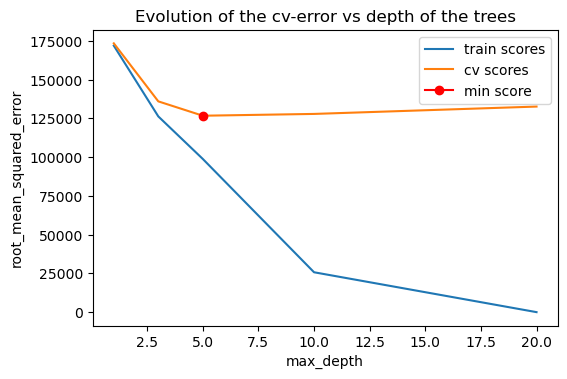

In [14]:
# Searching max-depth using k-cross-validation & neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Values tested
max_depths = [1, 3, 5, 10, 20]

# Loop for training the model for each valie in max_depth & obtining the training error
# and the k-cross-validation error.
for max_depth in max_depths:
    
    model = GradientBoostingRegressor(
                n_estimators = 100,
                loss         = 'squared_error',
                max_depth    = max_depth,
                max_features = 'sqrt',
                random_state = 123
             )
    
    # Training error
    model.fit(X_train, y_train)
    predictions = model.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predictions,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error of CV
    scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1
             )
    # Aggregation of scores of cross_val_score() and changing the sign
    cv_scores.append(-1*scores.mean())
    
# Graphic showing the error evolution
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_depths, train_scores, label="train scores")
ax.plot(max_depths, cv_scores, label="cv scores")
ax.plot(max_depths[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_depth")
ax.set_title("Evolution of the cv-error vs depth of the trees")
plt.legend();
print(f"Optimum value of max_depth: {max_depths[np.argmin(cv_scores)]}")

In [15]:
# Grid Seach based on CV

from sklearn.model_selection import ParameterGrid

# Grid of hiperparameters evaluated
# ==============================================================================
param_grid = {'max_features'  : ['auto', 'sqrt', 'log2'],
              'max_depth'     : [None, 1, 3, 5, 10, 20],
              'subsample'     : [0.5, 1],
              'learning_rate' : [0.001, 0.01, 0.1]
             }

# Gris search by CV
# ==============================================================================
grid = GridSearchCV(
        estimator  = GradientBoostingRegressor(
                        n_estimators        = 1000, 
                        random_state        = 123,
                        # Activation of early stop
                        validation_fraction = 0.1,
                        n_iter_no_change    = 5,
                        tol                 = 0.0001
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

param_learning_rate param_max_depth param_max_features param_subsample  \
62                0.01              10               sqrt             0.5   
63                0.01              10               sqrt               1   
64                0.01              10               log2             0.5   
65                0.01              10               log2               1   
38                0.01            None               sqrt             0.5   
93                 0.1               5               sqrt               1   
40                0.01            None               log2             0.5   
68                0.01              20               sqrt             0.5   
70                0.01              20               log2             0.5   
59                0.01               5               log2               1   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
62   -125122.669543     3842.299196     -56042.195626      2928.913487  
63   -126101.599126     3335.168383     -42381.700529      1715.719444  
64   -126122.309480     2549.483096     -57623.409348       253.872974  
65   -126268.176811     3332.694026     -45487.675395      1357.899647  
38   -126808.225966     3434.615536     -38069.503808      2889.619544  
93   -127289.801205     1841.652856     -88176.147006      3321.032482  
40   -127584.873069     3828.256580     -37845.781204      2618.196308  
68   -127751.624969     3955.430184     -41287.330943      2699.536777  
70   -128125.594346     3253.205931     -39748.305399      3014.804580  
59   -128227.015963     3679.276207     -97793.901932      3950.904836

In [16]:
# Best hiperparameters using CV
# ==============================================================================
print("----------------------------------------")
print("Best hiperparameters found (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Best hiperparameters found (cv)
----------------------------------------
{'learning_rate': 0.01, 'max_depth': 10, 'max_features': 'sqrt', 'subsample': 0.5} : -125122.6695429412 neg_root_mean_squared_error


In [17]:
# Although it has been indicated that n_estimator = 1000, due to the activation of 
# the early stop, the training may have stopped earlier.

# Number of trees of the final model (early stopping activated)
# ==============================================================================
print(f"Number of trees of the final model: {grid.best_estimator_.n_estimators_}")

Number of trees of the final model: 368


In [18]:
# Selecting Best model
model_final = grid.best_estimator_

In [19]:
# Final Model training error
#-------------------------------------------------------------------------------
prediction_train = model_final.predict(X = X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = prediction_train,
        squared = False
       )
print(f"RMSE in train: {rmse}")

R2 Value in training: 0.94
Accuracy in training 85.38
RMSE in train: 71087.32607158745


In [20]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = model_final.predict(X = X_test)


#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))
      
 
residuals_testn=y_test - prediction_test

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = prediction_test,
        squared = False
       )
print(f"RMSE in test: {rmse}")

Accuracy in test 69.89
RMSE in test: 120918.35343189324


In [21]:
importance_predictors = pd.DataFrame(
                            {'predictor': data_train.drop(columns = "latestPrice").columns,
                             'importance': model_final.feature_importances_}
                            )
print("Importance of the model predictors")
print("-------------------------------------------")
importance_predictors.sort_values('importance', ascending=False)

Importance of the model predictors
-------------------------------------------


predictor  importance
19  numOfPatioAndPorchFeatures    0.180297
28          numOfMiddleSchools    0.107388
0                      zipcode    0.086863
18        numOfParkingFeatures    0.078188
1                     latitude    0.076130
2                    longitude    0.058234
25              livingAreaSqFt    0.054756
5                   hasCooling    0.049854
26         numOfPrimarySchools    0.039628
24                 lotSizeSqFt    0.034008
27      numOfElementarySchools    0.033001
6                    hasGarage    0.025446
9                      hasView    0.023793
29            numOfHighSchools    0.018401
31             avgSchoolRating    0.016569
7                   hasHeating    0.012356
11                   yearBuilt    0.011000
3              propertyTaxRate    0.010736
4               hasAssociation    0.010526
30           avgSchoolDistance    0.010154
13            latest_salemonth    0.009333
8                       hasSpa    0.008494
23      numOfCommunityFeatures    0.007405
12             numPriceChanges    0.007175
14             latest_saleyear    0.005472
35               numOfBedrooms    0.004982
21     numOfWaterfrontFeatures    0.004364
16  numOfAccessibilityFeatures    0.003537
36                numOfStories    0.003252
33    MedianStudentsPerTeacher    0.002429
20       numOfSecurityFeatures    0.002020
32               avgSchoolSize    0.001044
22         numOfWindowFeatures    0.000952
34              numOfBathrooms    0.000790
15                 numOfPhotos    0.000709
10               parkingSpaces    0.000501
17             numOfAppliances    0.000213

In [22]:
from sklearn.inspection import permutation_importance

importance_per = permutation_importance(
                estimator    = model_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importance = pd.DataFrame(
                    {k: importance_per[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importance['feature'] = X_train.columns
df_importance.sort_values('importances_mean', ascending=False)

importances_mean  importances_std                     feature
19      97799.205101       712.781688              livingAreaSqFt
0       49610.763070       520.296753                     zipcode
1       38009.239814       732.060081                    latitude
28      33799.617011       538.637082              numOfBathrooms
18      32495.201370       271.124877                 lotSizeSqFt
25      28600.586384       492.913117             avgSchoolRating
2       26641.583554       238.445048                   longitude
5       21393.981545       223.256447                   yearBuilt
6       17787.777103       151.462146             numPriceChanges
26      14840.360516       565.970923               avgSchoolSize
27      13765.933488       387.524787    MedianStudentsPerTeacher
24      10051.908123       248.681111           avgSchoolDistance
9        9235.538789       189.740429                 numOfPhotos
31       6444.076729       169.046037        Dmy_association_True
29       5821.907155       112.725282               numOfBedrooms
8        5412.162146       185.536352             latest_saleyear
3        4481.481541        83.600660             propertyTaxRate
13       3598.546969       126.880363  numOfPatioAndPorchFeatures
7        3572.960390       141.480147            latest_salemonth
4        3219.365560        68.569916               parkingSpaces
30       3002.346694       118.710433                numOfStories
11       2911.075001        37.147966             numOfAppliances
12       1976.670946        67.745902        numOfParkingFeatures
35       1696.752786        34.859728                Dmy_spa_True
23       1599.051826        90.421535            numOfHighSchools
14       1518.179747       100.617482       numOfSecurityFeatures
21       1504.280148        44.841821      numOfElementarySchools
36       1232.135019        63.982738               Dmy_view_True
33        885.003844        27.168235             Dmy_garage_True
16        821.462894        11.509984         numOfWindowFeatures
20        515.447252        10.864155         numOfPrimarySchools
32        221.495891         9.007380            Dmy_cooling_True
34        175.733398        10.924748            Dmy_heating_True
22        155.987245         6.534705          numOfMiddleSchools
15        129.826246         7.271729     numOfWaterfrontFeatures
10         93.477444         9.639252  numOfAccessibilityFeatures
17         37.197608         9.029020      numOfCommunityFeatures

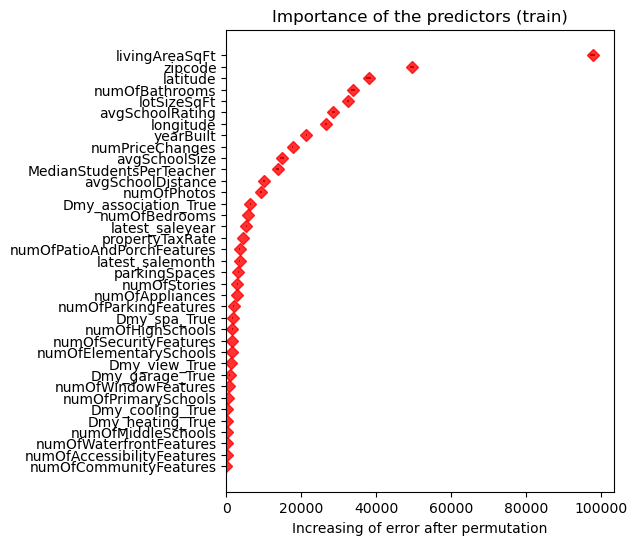

In [23]:
# Graphic
fig, ax = plt.subplots(figsize=(5, 6))
df_importance = df_importance.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importance['feature'],
    df_importance['importances_mean'],
    xerr=df_importance['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importance['importances_mean'],
    df_importance['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');

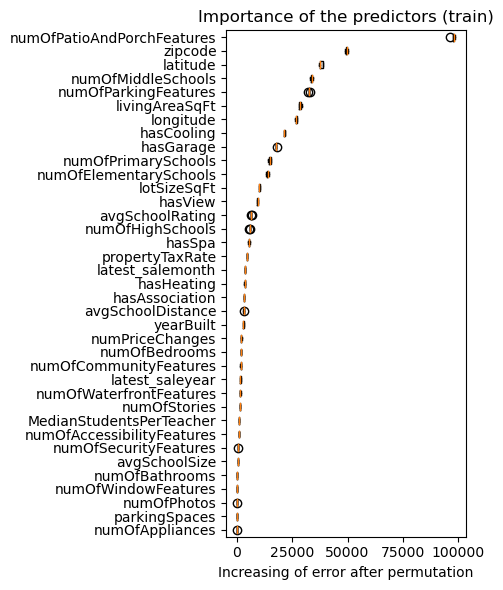

In [24]:
# Graphic Alternative
fig, ax = plt.subplots(figsize=(5, 6))
sorted_idx = importance_per.importances_mean.argsort()
ax.boxplot(
        importance_per.importances[sorted_idx].T,
        vert   = False,
        labels = data_train.drop(columns = "latestPrice").columns[sorted_idx]
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');
fig.tight_layout();

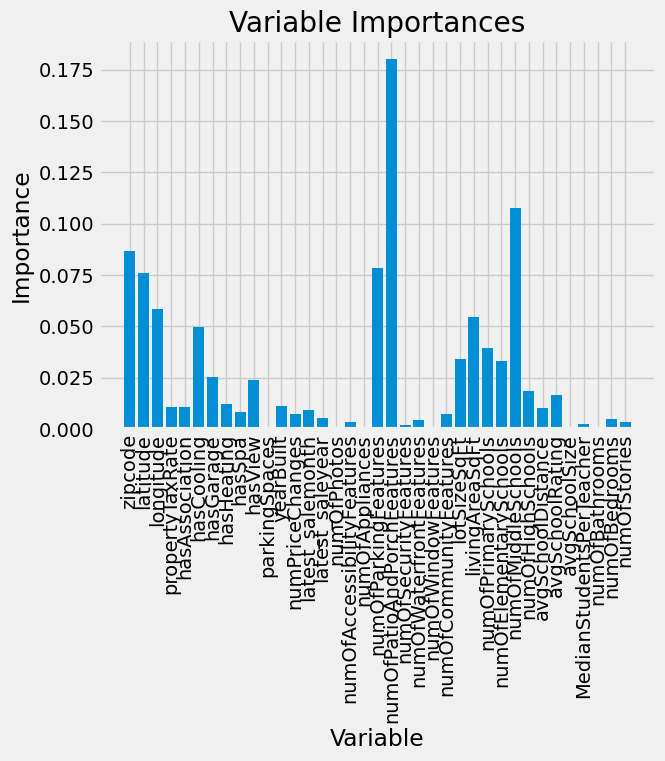

In [25]:
importances= model_final.feature_importances_
feature_list = data_train.drop(columns = "latestPrice").columns

%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

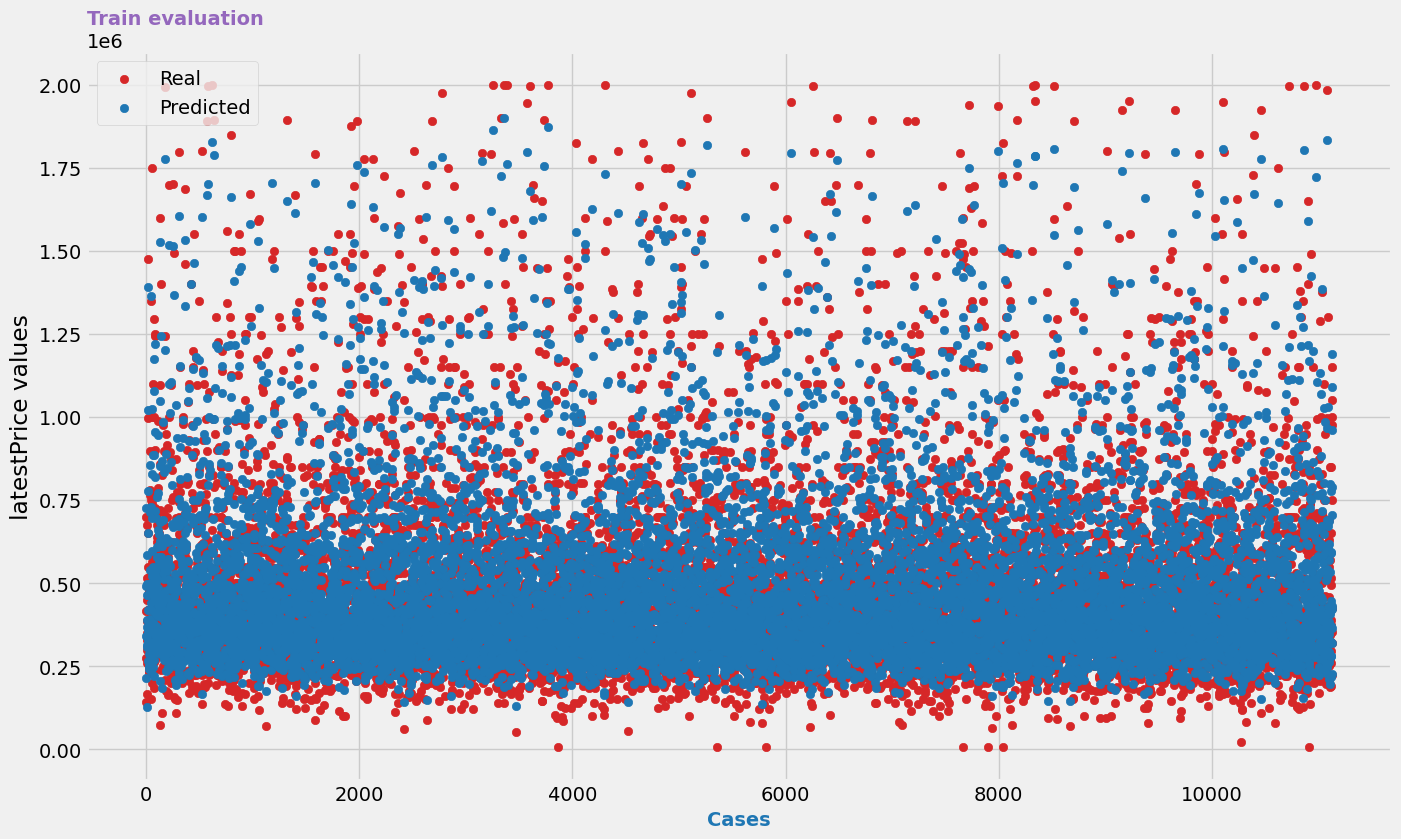

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_train)))

ax.scatter(x_axis, y_train, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

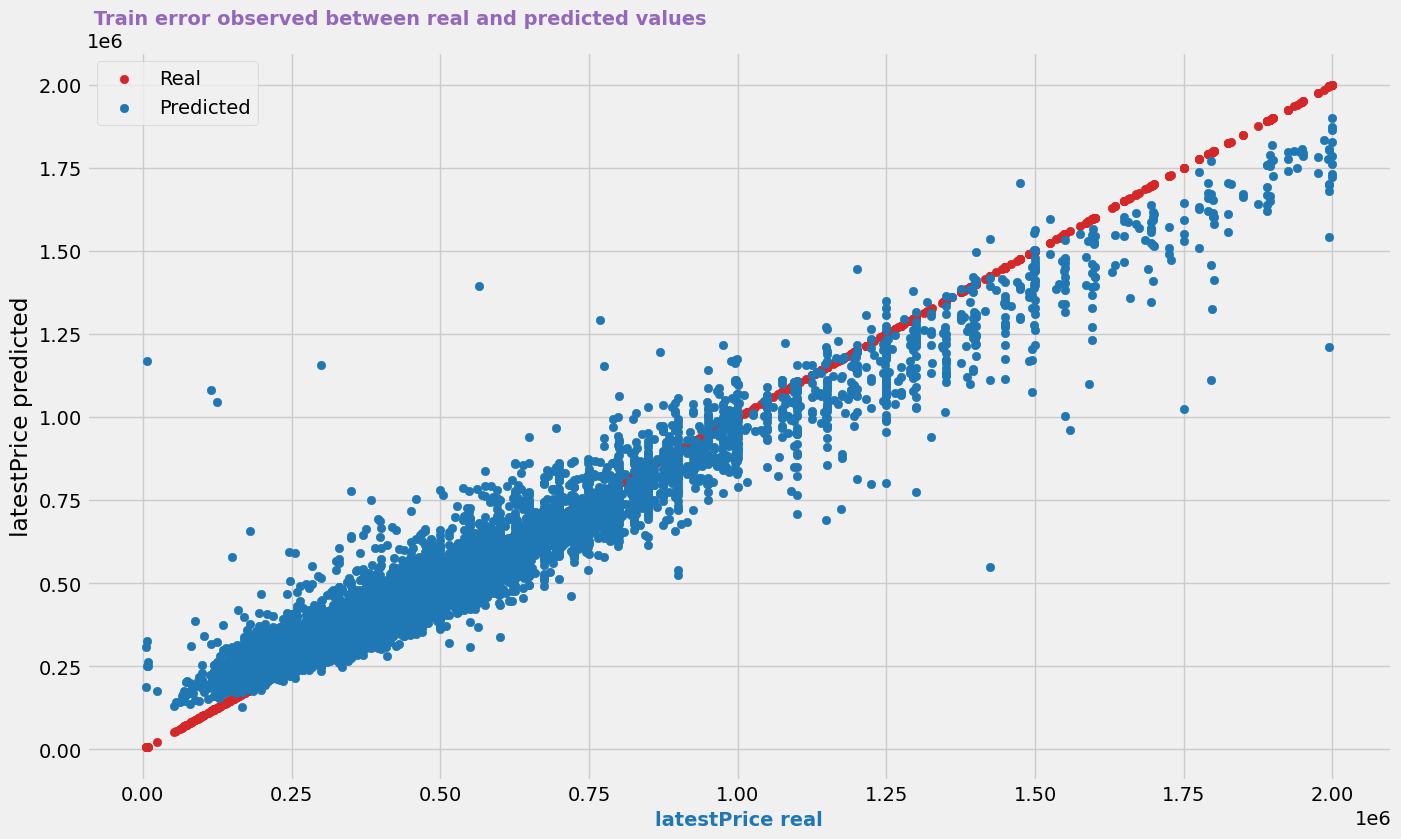

In [27]:
#######  TRAIN

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_train, y_train, color = 'tab:red', label='Real')
ax.scatter(y_train, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice real", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice predicted")
ax.set_title(' Train error observed between real and predicted values', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

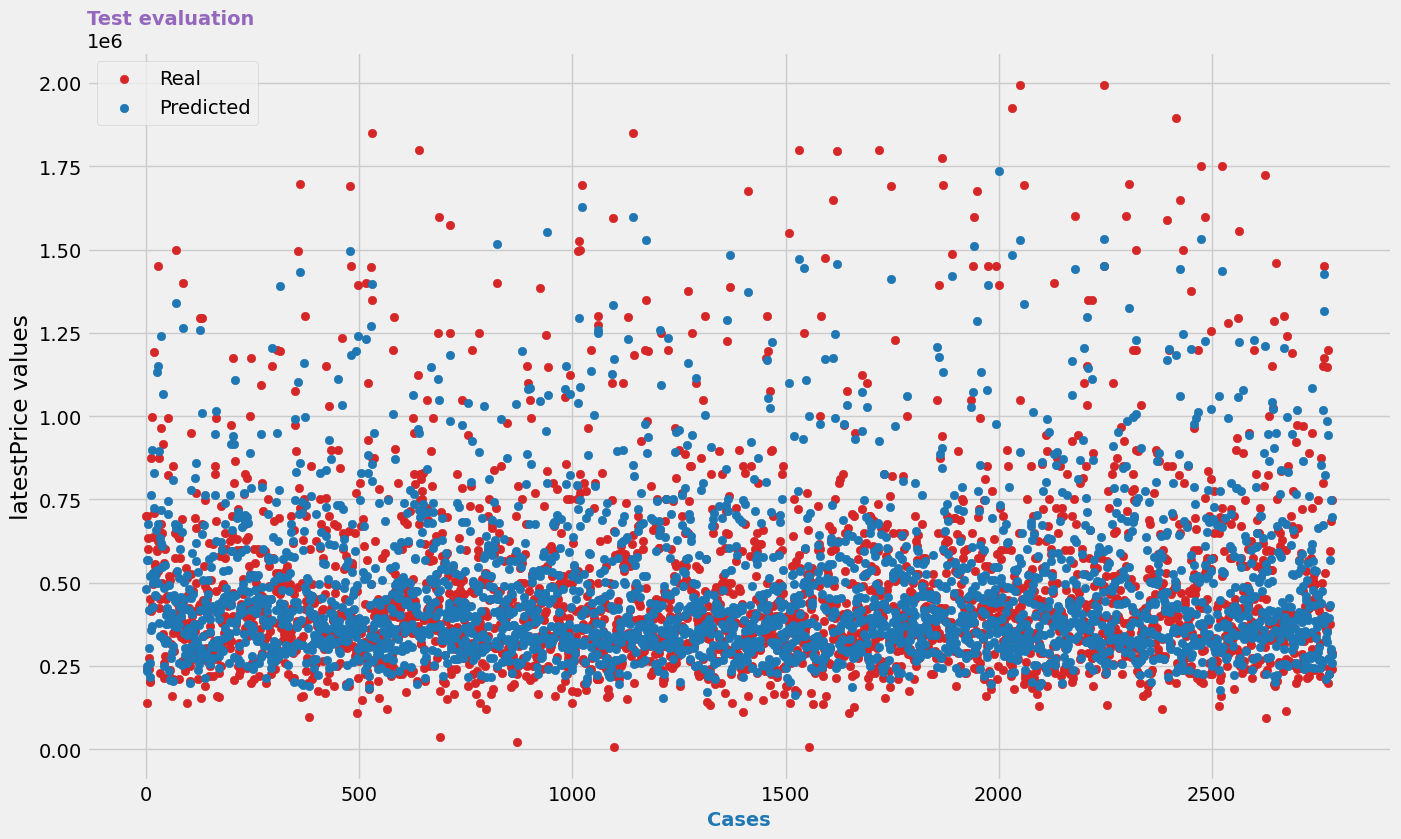

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_test)))

ax.scatter(x_axis, y_test, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

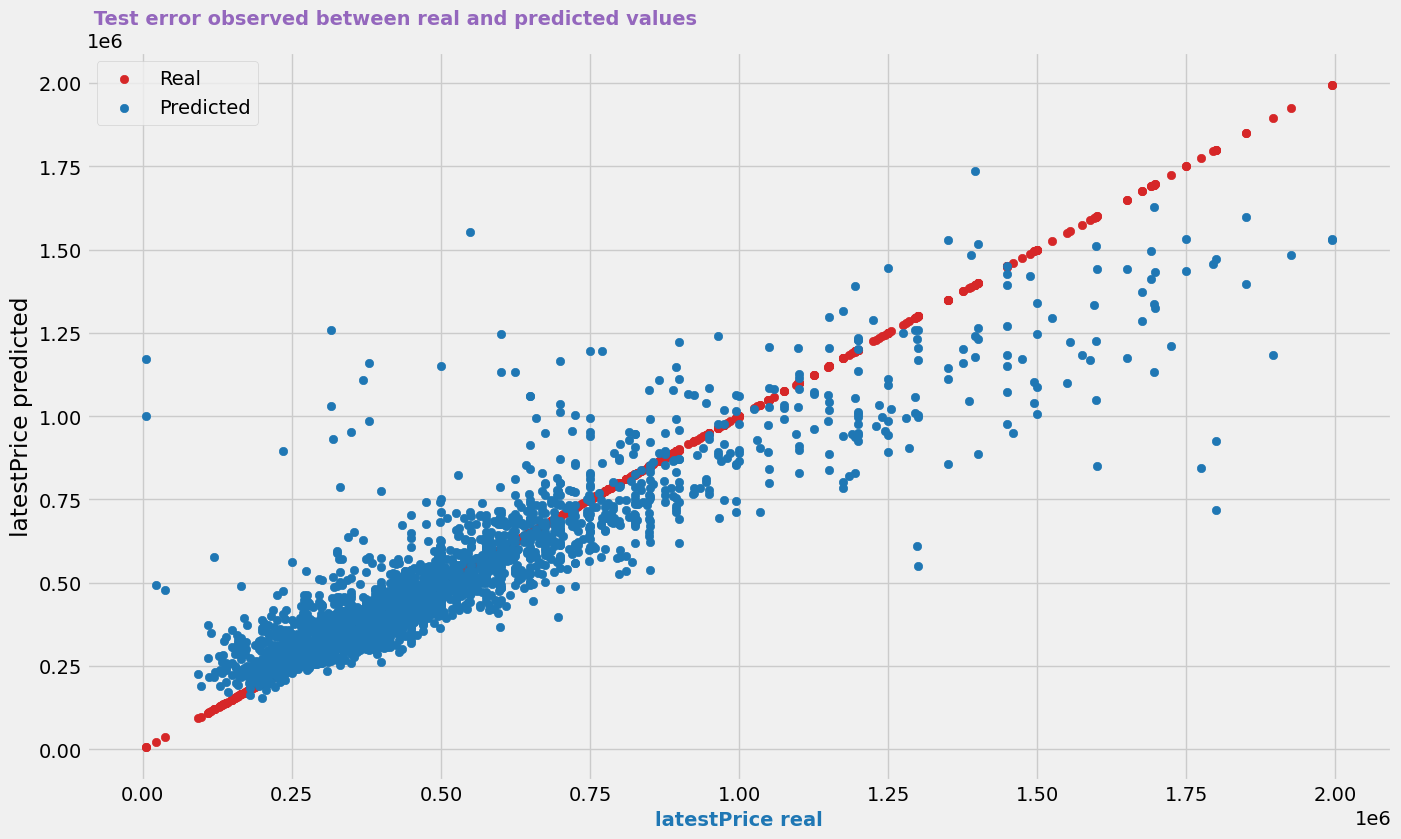

In [29]:
#######  TEST

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_test, y_test, color = 'tab:red', label='Real')
ax.scatter(y_test, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice real", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice predicted")
ax.set_title(' Test error observed between real and predicted values', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

In [30]:
# Model based on XGBoost:
# - Allows observations to include missing values
# - Allows the use of GPUs
# - Parallelized training (parallelizes some parts of the algorithm)
# - Allow monotonic constraints
# - Allows working on sparse matrices
# - Required one-hot-encoding of categorical variables

In [31]:
# Instalación XGBoost: conda install -c conda-forge xgboost
from xgboost import XGBRegressor

In [32]:
# Grid of the hipermarameters to evaluate
# ==============================================================================
param_grid = {'max_depth'        : [None, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'booster'          : ['gbtree']
             }


# Creation of a validation dataset
# ==============================================================================
np.random.seed(123)
idx_validacion = np.random.choice(
                    X_train.shape[0],
                    size= int(X_train.shape[0]*0.1),
                    replace=False
                 )

X_val = X_train.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()

X_train_grid = X_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()
y_train_grid = y_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()

# XGBoost requires to pass the specific parameters for training calling the methodd .fit()
fit_params = {"early_stopping_rounds" : 5, 
              "eval_metric"           : "rmse", 
              "eval_set"              : [(X_val, y_val)],
              "verbose"               : 0
             }

# grid search with CV
# ==============================================================================
grid = GridSearchCV(
        estimator  = XGBRegressor(
                        n_estimators = 1000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_grid, y = y_train_grid, **fit_params)

# Results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

/Users/santi/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/santi/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/santi/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/santi/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in construct

param_booster param_learning_rate param_max_depth param_subsample  \
20        gbtree                0.01              10             0.5   
12        gbtree                0.01            None             0.5   
31        gbtree                 0.1               5               1   
22        gbtree                0.01              20             0.5   
32        gbtree                 0.1              10             0.5   
13        gbtree                0.01            None               1   
19        gbtree                0.01               5               1   
18        gbtree                0.01               5             0.5   
30        gbtree                 0.1               5             0.5   
25        gbtree                 0.1            None               1   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
20   -128449.571757     1943.498364     -58499.171862      4330.631642  
12   -129595.141358      533.069201     -91213.804892      5471.969856  
31   -129685.408271      423.454272     -88237.743285      4148.658710  
22   -129692.296204     1921.500315     -45012.049320      1905.558584  
32   -130111.260069     1518.921665     -55695.251658      5028.387565  
13   -130272.797351      916.955876     -78243.856067      4308.719675  
19   -130564.966627      676.499759     -94267.767455      5780.094642  
18   -130708.175345     1237.616684    -102386.187763      2365.273941  
30   -131405.982803     1187.266957     -99077.777899      1856.468228  
25   -131453.517129      275.580236     -81965.126661      7275.336191

In [33]:
# Best hiperparameters using CV
# ==============================================================================
print("----------------------------------------")
print("Best hiperparameters found (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Best hiperparameters found (cv)
----------------------------------------
{'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.5} : -128449.571757065 neg_root_mean_squared_error


In [34]:
# Number of trees of the final model (early stopping activated)
# ==============================================================================
n_trees_included = len(grid.best_estimator_.get_booster().get_dump())
print(f"Number of trees included in the model: {n_trees_included}")

Number of trees included in the model: 320


In [35]:
from sklearn.inspection import permutation_importance

importance_per = permutation_importance(
                estimator    = model_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importance = pd.DataFrame(
                    {k: importance_per[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importance['feature'] = X_train.columns
df_importance.sort_values('importances_mean', ascending=False)

importances_mean  importances_std                     feature
19      97799.205101       712.781688              livingAreaSqFt
0       49610.763070       520.296753                     zipcode
1       38009.239814       732.060081                    latitude
28      33799.617011       538.637082              numOfBathrooms
18      32495.201370       271.124877                 lotSizeSqFt
25      28600.586384       492.913117             avgSchoolRating
2       26641.583554       238.445048                   longitude
5       21393.981545       223.256447                   yearBuilt
6       17787.777103       151.462146             numPriceChanges
26      14840.360516       565.970923               avgSchoolSize
27      13765.933488       387.524787    MedianStudentsPerTeacher
24      10051.908123       248.681111           avgSchoolDistance
9        9235.538789       189.740429                 numOfPhotos
31       6444.076729       169.046037        Dmy_association_True
29       5821.907155       112.725282               numOfBedrooms
8        5412.162146       185.536352             latest_saleyear
3        4481.481541        83.600660             propertyTaxRate
13       3598.546969       126.880363  numOfPatioAndPorchFeatures
7        3572.960390       141.480147            latest_salemonth
4        3219.365560        68.569916               parkingSpaces
30       3002.346694       118.710433                numOfStories
11       2911.075001        37.147966             numOfAppliances
12       1976.670946        67.745902        numOfParkingFeatures
35       1696.752786        34.859728                Dmy_spa_True
23       1599.051826        90.421535            numOfHighSchools
14       1518.179747       100.617482       numOfSecurityFeatures
21       1504.280148        44.841821      numOfElementarySchools
36       1232.135019        63.982738               Dmy_view_True
33        885.003844        27.168235             Dmy_garage_True
16        821.462894        11.509984         numOfWindowFeatures
20        515.447252        10.864155         numOfPrimarySchools
32        221.495891         9.007380            Dmy_cooling_True
34        175.733398        10.924748            Dmy_heating_True
22        155.987245         6.534705          numOfMiddleSchools
15        129.826246         7.271729     numOfWaterfrontFeatures
10         93.477444         9.639252  numOfAccessibilityFeatures
17         37.197608         9.029020      numOfCommunityFeatures

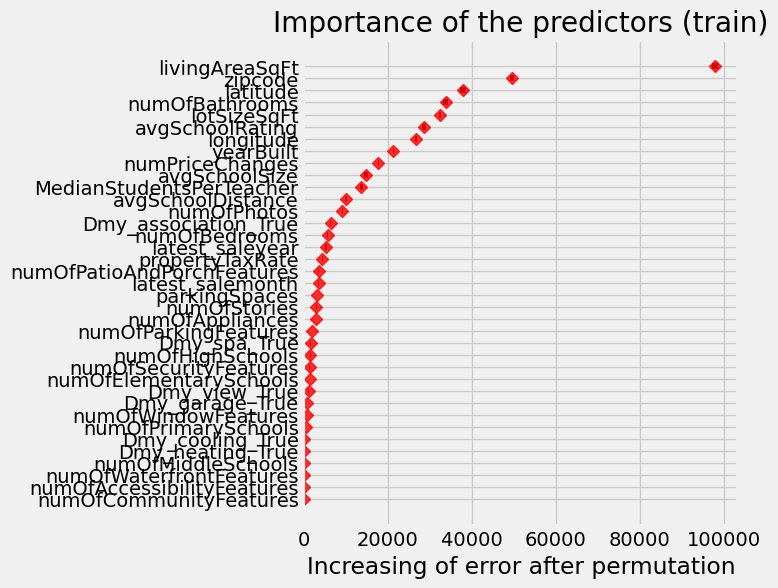

In [36]:
# Graphic
fig, ax = plt.subplots(figsize=(5, 6))
df_importance = df_importance.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importance['feature'],
    df_importance['importances_mean'],
    xerr=df_importance['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importance['importances_mean'],
    df_importance['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');

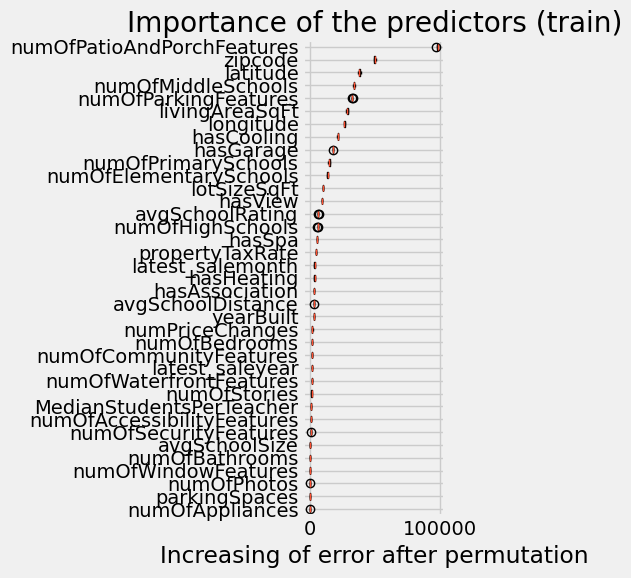

In [37]:
# Graphic Alternative
fig, ax = plt.subplots(figsize=(5, 6))
sorted_idx = importance_per.importances_mean.argsort()
ax.boxplot(
        importance_per.importances[sorted_idx].T,
        vert   = False,
        labels = data_train.drop(columns = "latestPrice").columns[sorted_idx]
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');
fig.tight_layout();

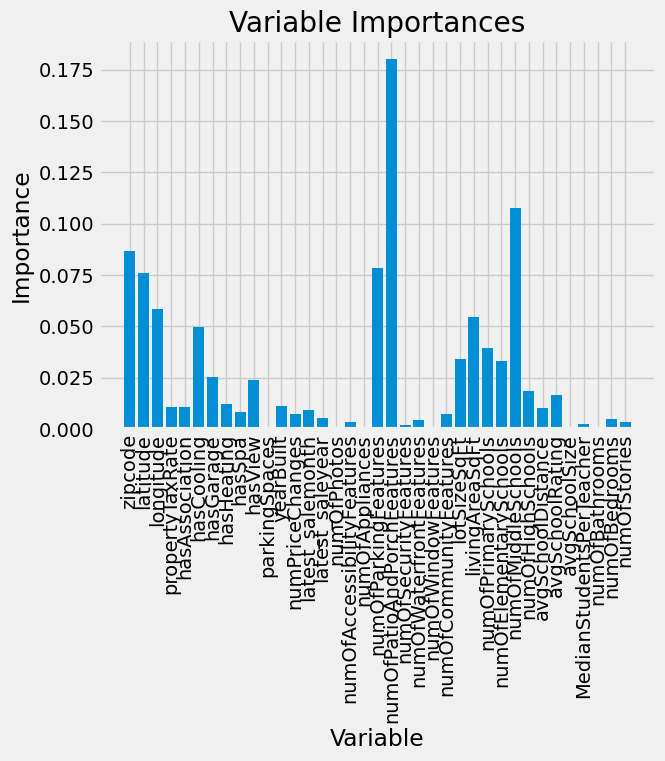

In [38]:
importances= model_final.feature_importances_
feature_list = data_train.drop(columns = "latestPrice").columns

%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [39]:
# Model training error
#-------------------------------------------------------------------------------
prediction_train = model_final.predict(X = X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = prediction_train,
        squared = False
       )
print(f"RMSE in train: {rmse}")

R2 Value in training: 0.94
Accuracy in training 85.38
RMSE in train: 71087.32607158745


In [40]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = model_final.predict(X = X_test)


#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))
      
 
residuals_testn=y_test - prediction_test

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = prediction_test,
        squared = False
       )
print(f"RMSE in test: {rmse}")

Accuracy in test 69.89
RMSE in test: 120918.35343189324


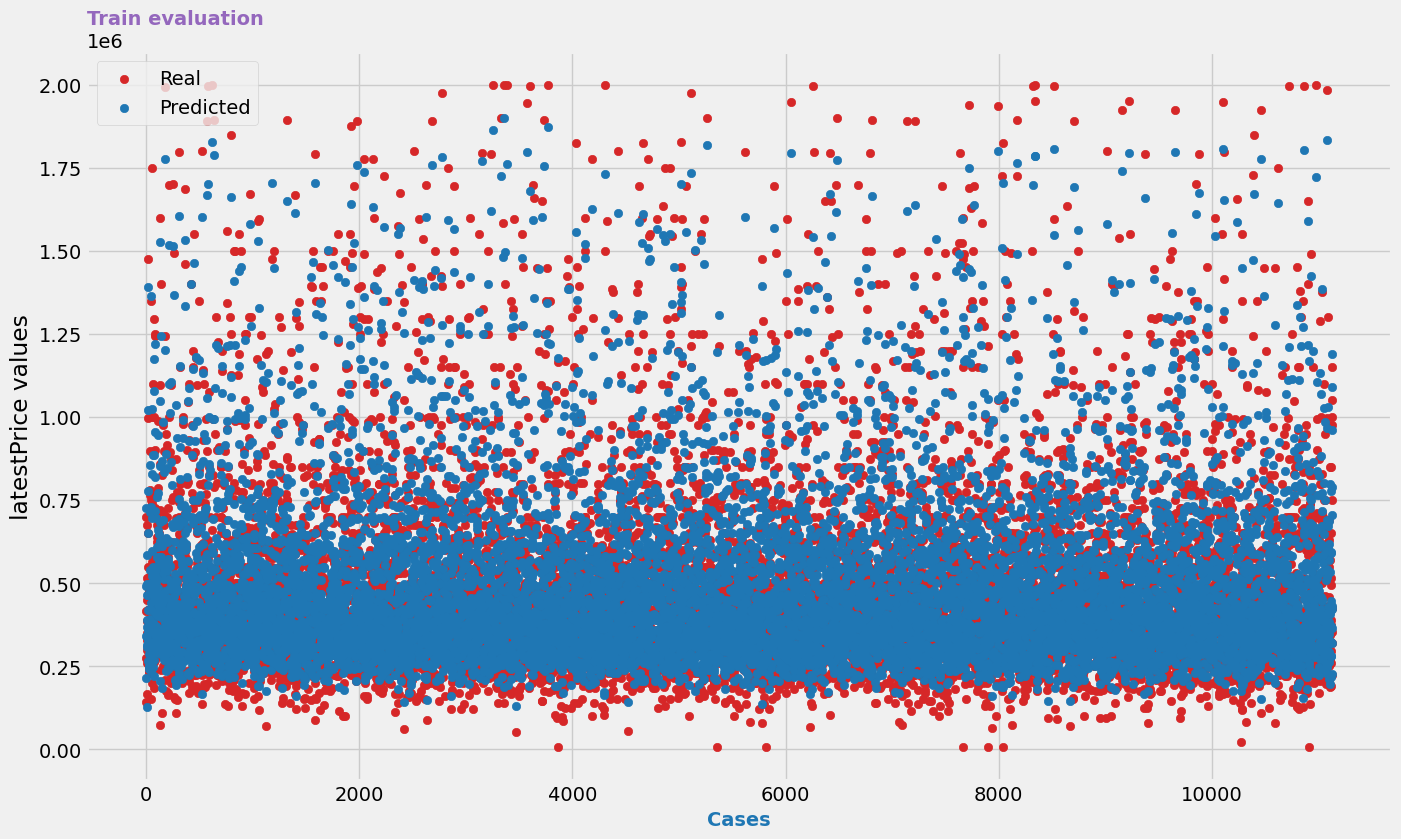

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_train)))

ax.scatter(x_axis, y_train, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

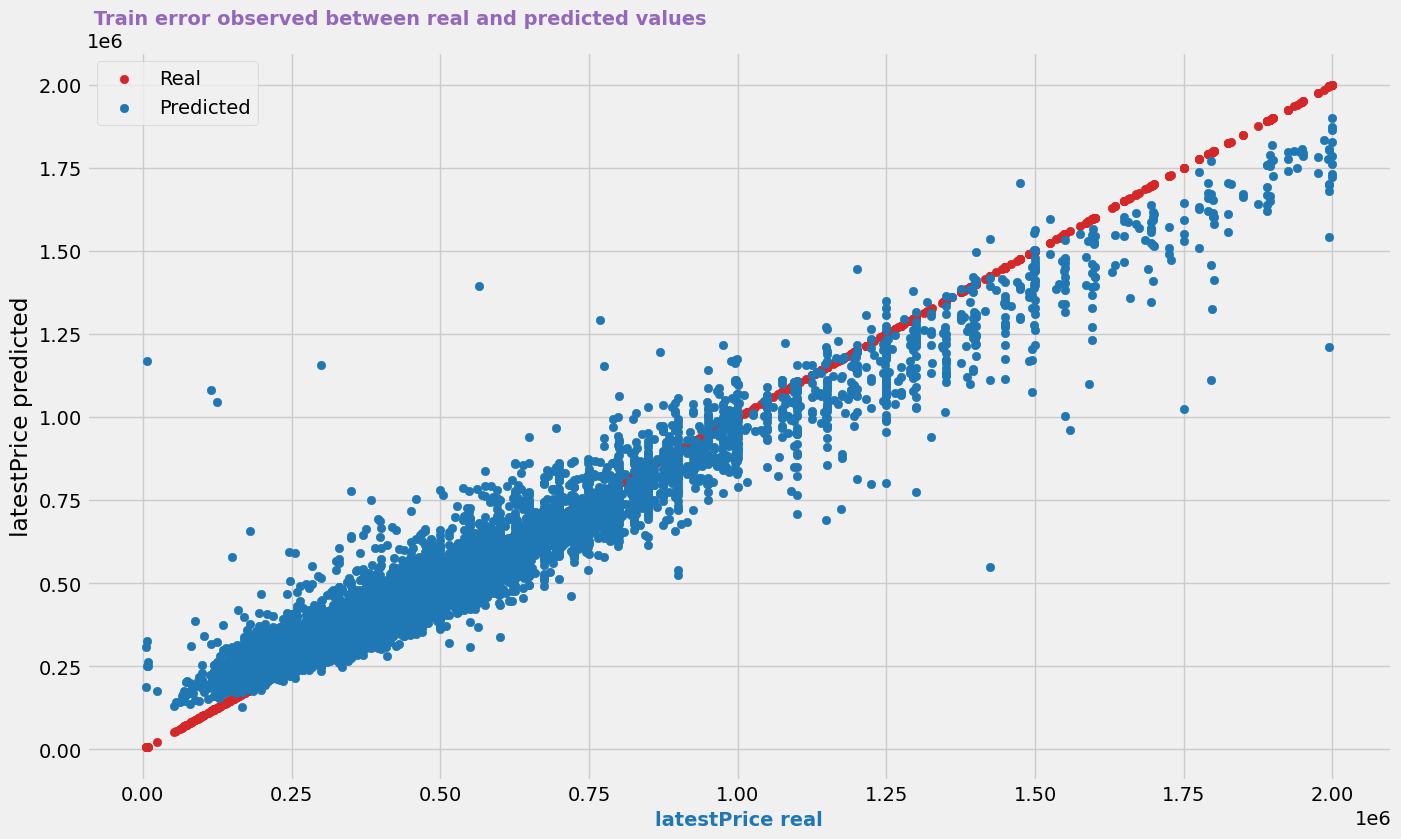

In [42]:
#######  TRAIN

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_train, y_train, color = 'tab:red', label='Real')
ax.scatter(y_train, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice real", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice predicted")
ax.set_title(' Train error observed between real and predicted values', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

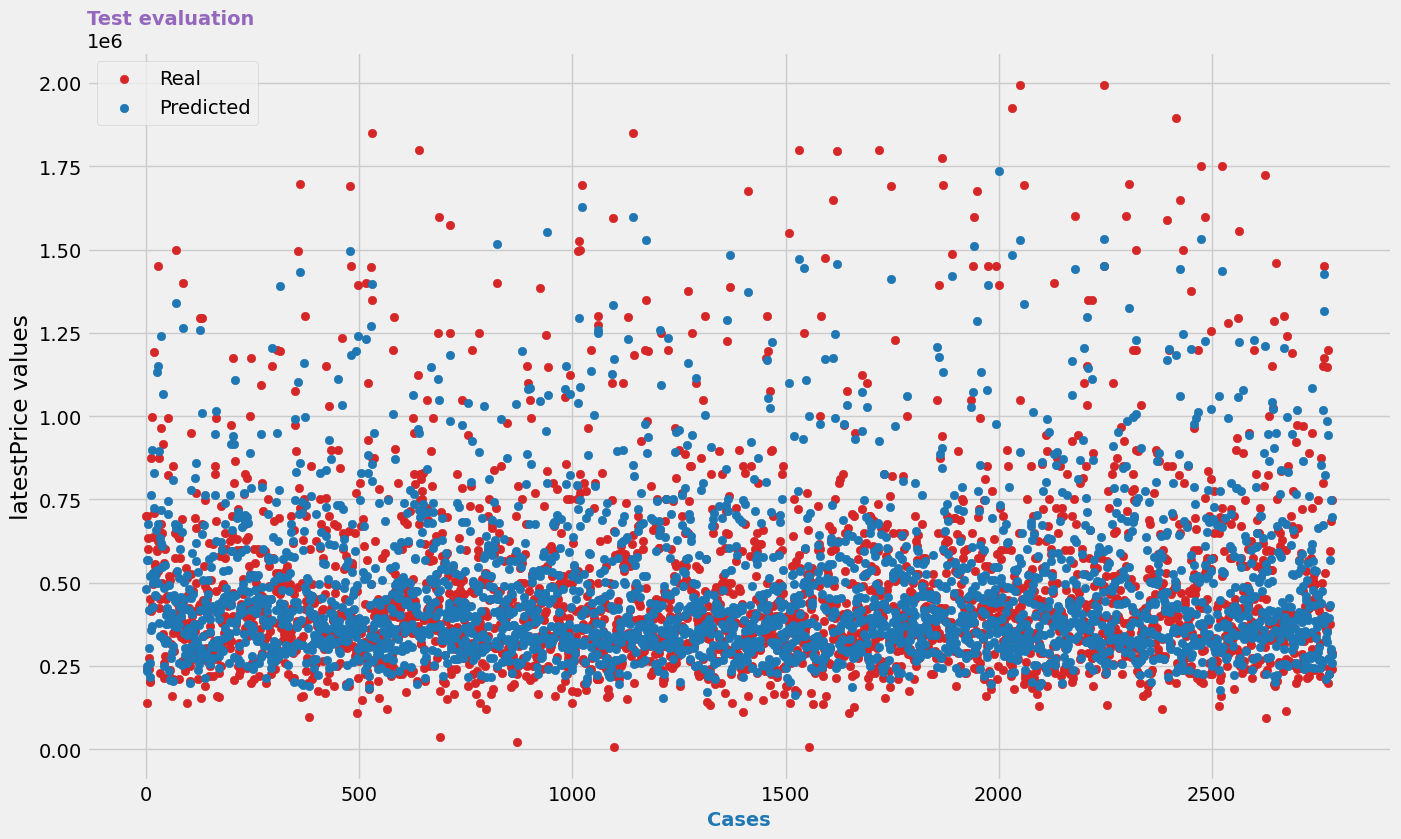

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_test)))

ax.scatter(x_axis, y_test, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

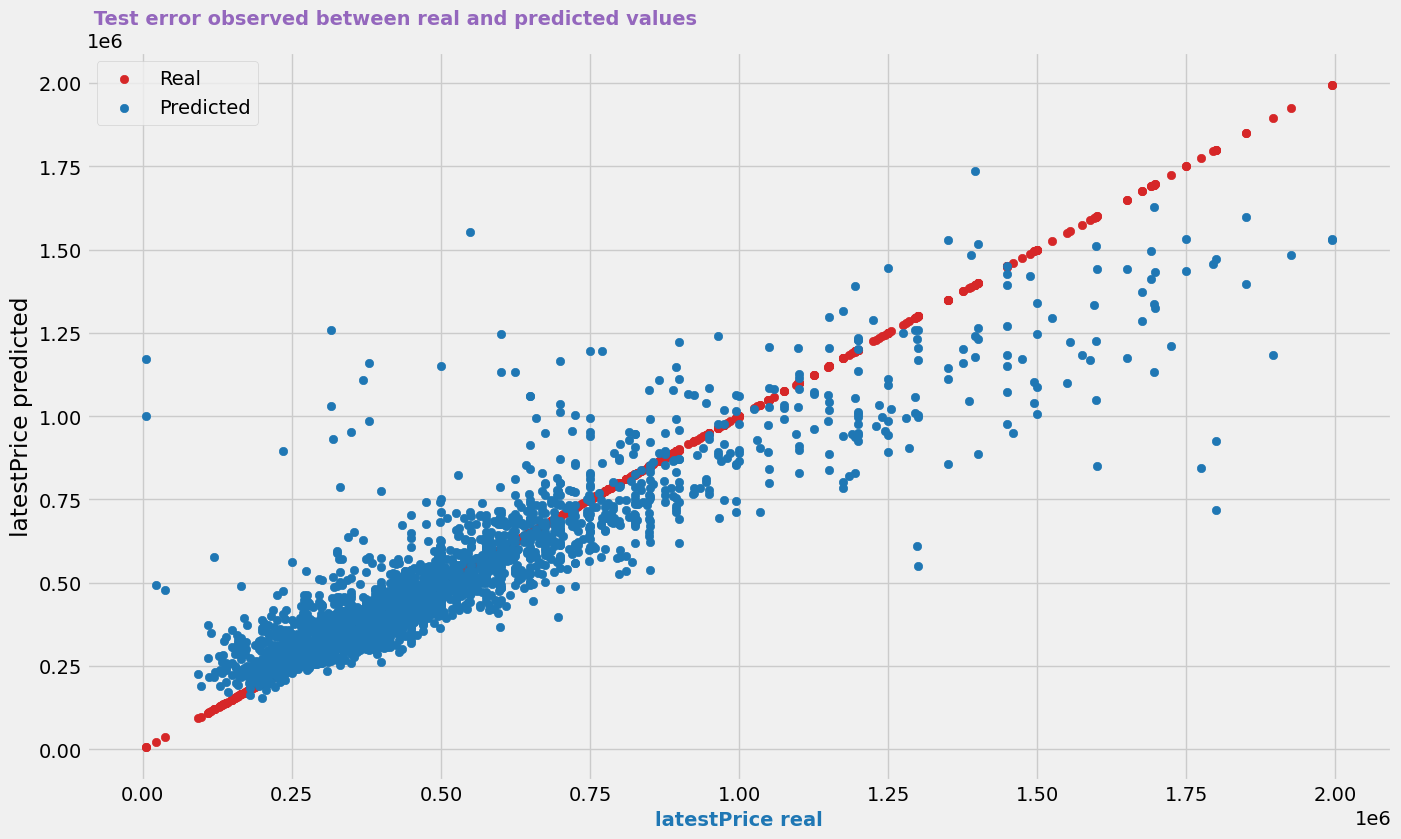

In [44]:
#######  TEST

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_test, y_test, color = 'tab:red', label='Real')
ax.scatter(y_test, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice real", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice predicted")
ax.set_title(' Test error observed between real and predicted values', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

In [45]:
# Model based on LightGBM
# - Allows observations to include missing values
# - Allows the use of GPUs
# - Parallelized training (parallelizes some parts of the algorithm)
# - Allow monotonic constraints
# - Allows working on sparse matrices
# - No need for one-hot-encoding of categorical variables


In [46]:
# Installation LightGBM: conda install -c conda-forge lightgbm
from lightgbm.sklearn import LGBMRegressor

In [47]:
# Grid of hiperparameters to evaluate 
# ==============================================================================
param_grid = {'n_estimators'     : [100, 500, 1000],
              'max_depth'        : [-1, 1, 3, 5, 10],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'boosting_type'    : ['gbdt']
             }

# grid search with CV
# ==============================================================================
grid = GridSearchCV(
        estimator  = LGBMRegressor(random_state=123,
                                   min_split_gain=0.1
                                   ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True,
       )

grid.fit(X = X_train_grid, y = y_train_grid)

# Resultados
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1786
[LightGBM] [Info] Number of data points in the train set: 6679, number of used features: 36
[LightGBM] [Info] Start training from score 483276.903129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1797
[LightGBM] [Info] Number of data points in the train set: 6679, number of used features: 36
[LightGBM] [Info] Start training from score 489660.434796
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

param_boosting_type param_learning_rate param_max_depth param_n_estimators  \
59                gbdt                0.01              10               1000   
58                gbdt                0.01              10               1000   
35                gbdt                0.01              -1               1000   
34                gbdt                0.01              -1               1000   

   param_subsample  mean_test_score  std_test_score  mean_train_score  \
59               1   -127303.403018     1564.989208     -76456.011843   
58             0.5   -127303.403018     1564.989208     -76456.011843   
35               1   -127510.976731     1592.138602     -74876.211677   
34             0.5   -127510.976731     1592.138602     -74876.211677   

    std_train_score  
59       661.756729  
58       661.756729  
35       738.565569  
34       738.565569

In [48]:
# Best hiperparameters using CV
# ==============================================================================
print("----------------------------------------")
print("Best hiperparameters found (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Best hiperparameters found (cv)
----------------------------------------
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.5} : -127303.40301802506 neg_root_mean_squared_error


In [49]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 10,
    'n_estimators': 500, 
    'subsample' : 0.5,
    'num_leaves': 31,    
    'verbose': -1,
    'early_stopping_rounds' : 50,
}

In [50]:
#train_data = lightgbm.Dataset(X_train, label=y_train)
#valid_data = lightgbm.Dataset(X_test, label=y_test)

In [51]:
#model_light_final = lightgbm.train(params, train_data, 1000, valid_sets=[train_data, valid_data])

In [52]:
# Selecting Best model
model_light_final = grid.best_estimator_

In [53]:
# Final Model training error
#-------------------------------------------------------------------------------
prediction_train = model_light_final.predict(X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = prediction_train,
        squared = False
       )
print(f"RMSE in train: {rmse}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
R2 Value in training: 0.9
Accuracy in training 80.27
RMSE in train: 90171.39544064907


In [54]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = model_light_final.predict(X_test)


#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))
      
 
residuals_testn=y_test - prediction_test

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = prediction_test,
        squared = False
       )
print(f"RMSE in test: {rmse}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy in test 70.87
RMSE in test: 121488.27894327733


In [55]:
importance_predictors = pd.DataFrame(
                            {'predictor': data_train.drop(columns = "latestPrice").columns,
                             'importance': model_light_final.feature_importances_}
                            )
print("Importance of the model predictors")
print("-------------------------------------------")
importance_predictors.sort_values('importance', ascending=False)

Importance of the model predictors
-------------------------------------------


predictor  importance
19  numOfPatioAndPorchFeatures        3578
1                     latitude        3129
18        numOfParkingFeatures        2847
5                   hasCooling        2759
2                    longitude        2735
0                      zipcode        1898
6                    hasGarage        1878
24                 lotSizeSqFt        1701
9                      hasView        1502
26         numOfPrimarySchools         933
25              livingAreaSqFt         917
28          numOfMiddleSchools         764
7                   hasHeating         753
8                       hasSpa         581
11                   yearBuilt         496
29            numOfHighSchools         412
4               hasAssociation         366
27      numOfElementarySchools         320
30           avgSchoolDistance         305
31             avgSchoolRating         290
12             numPriceChanges         243
14             latest_saleyear         229
13            latest_salemonth         220
3              propertyTaxRate         207
35               numOfBedrooms         144
36                numOfStories         124
16  numOfAccessibilityFeatures          52
21     numOfWaterfrontFeatures          52
32               avgSchoolSize          48
34              numOfBathrooms          46
23      numOfCommunityFeatures          45
10               parkingSpaces          42
22         numOfWindowFeatures          37
20       numOfSecurityFeatures          31
17             numOfAppliances          17
33    MedianStudentsPerTeacher           2
15                 numOfPhotos           0

In [56]:
from sklearn.inspection import permutation_importance

importance_per = permutation_importance(
                estimator    = model_light_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importance = pd.DataFrame(
                    {k: importance_per[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importance['feature'] = X_train.columns
df_importance.sort_values('importances_mean', ascending=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

importances_mean  importances_std                     feature
19     130371.581570       849.497638              livingAreaSqFt
0       64673.168864       621.746672                     zipcode
1       44610.070606       642.522533                    latitude
2       28386.370085       284.892790                   longitude
25      26500.508381       171.039601             avgSchoolRating
18      26192.687932       399.575355                 lotSizeSqFt
6       24725.030019       277.175486             numPriceChanges
5       16895.362904       242.077465                   yearBuilt
28      11634.815961       298.933037              numOfBathrooms
8        6068.621382       370.449163             latest_saleyear
31       5913.534625       368.294093        Dmy_association_True
9        5820.337730       204.869394                 numOfPhotos
26       4954.738648       254.838388               avgSchoolSize
24       3893.870365       229.433441           avgSchoolDistance
7        3454.846920       397.927381            latest_salemonth
29       2597.832418       137.240960               numOfBedrooms
3        2252.613167       106.501353             propertyTaxRate
11       1495.331498       100.047013             numOfAppliances
27       1288.388657        33.130983    MedianStudentsPerTeacher
30       1172.207316        46.657069                numOfStories
4         956.794812       116.296223               parkingSpaces
12        922.242233        66.010592        numOfParkingFeatures
35        843.341410        83.351302                Dmy_spa_True
14        698.542212        76.479364       numOfSecurityFeatures
13        669.712556        43.066119  numOfPatioAndPorchFeatures
36        338.736792        22.132359               Dmy_view_True
21        226.948564        17.671158      numOfElementarySchools
23        125.359325         4.609836            numOfHighSchools
32        117.246235        23.939085            Dmy_cooling_True
16         88.638514        11.706235         numOfWindowFeatures
20         55.580366        10.072042         numOfPrimarySchools
34         46.838064         4.915556            Dmy_heating_True
10         32.935363        11.375185  numOfAccessibilityFeatures
17         26.465660         9.514375      numOfCommunityFeatures
22         18.836955         4.278874          numOfMiddleSchools
33          0.673081         0.315497             Dmy_garage_True
15          0.000000         0.000000     numOfWaterfrontFeatures

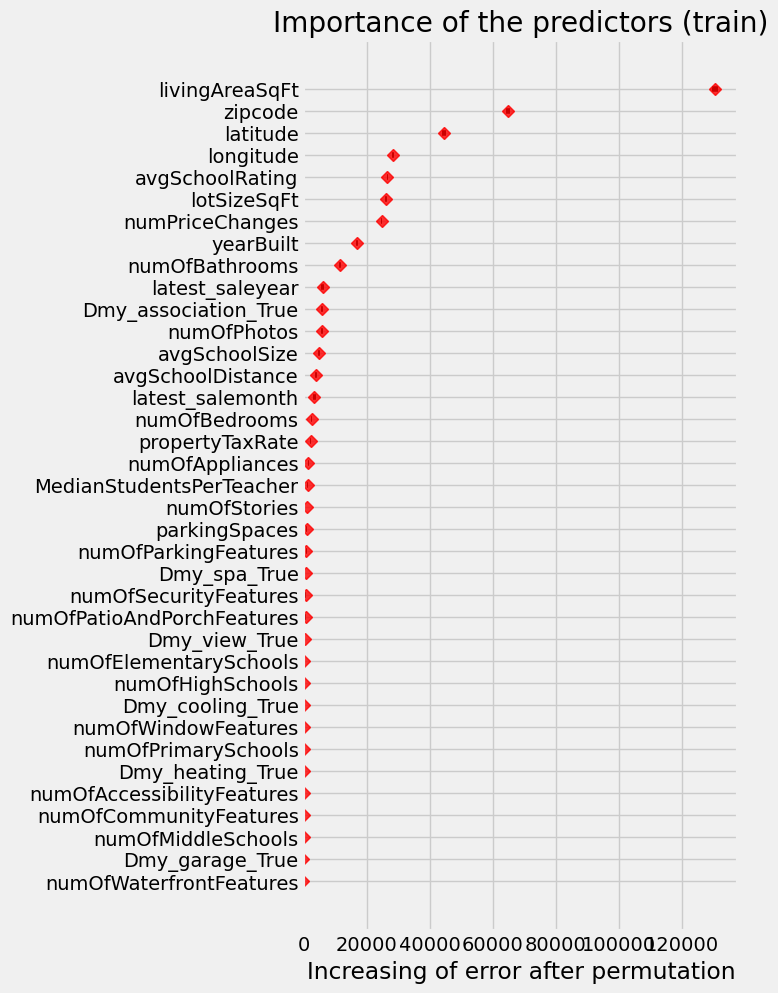

In [57]:
# Graphic
fig, ax = plt.subplots(figsize=(5, 11))
df_importance = df_importance.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importance['feature'],
    df_importance['importances_mean'],
    xerr=df_importance['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importance['importances_mean'],
    df_importance['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');

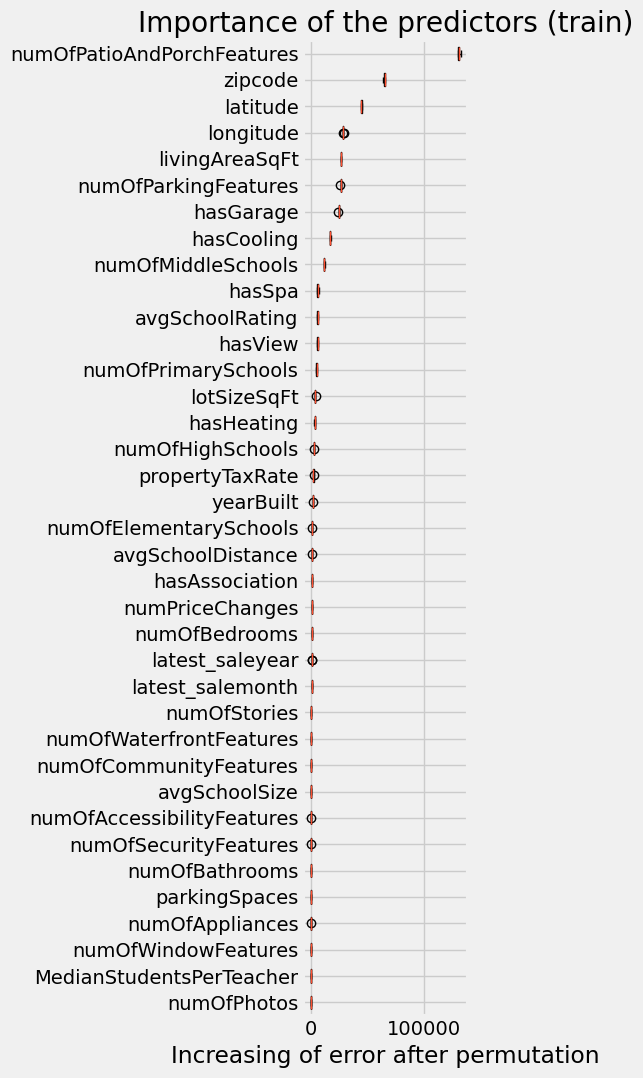

In [58]:
# Graphic Alternative
fig, ax = plt.subplots(figsize=(5, 11))
sorted_idx = importance_per.importances_mean.argsort()
ax.boxplot(
        importance_per.importances[sorted_idx].T,
        vert   = False,
        labels = data_train.drop(columns = "latestPrice").columns[sorted_idx]
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');
fig.tight_layout();

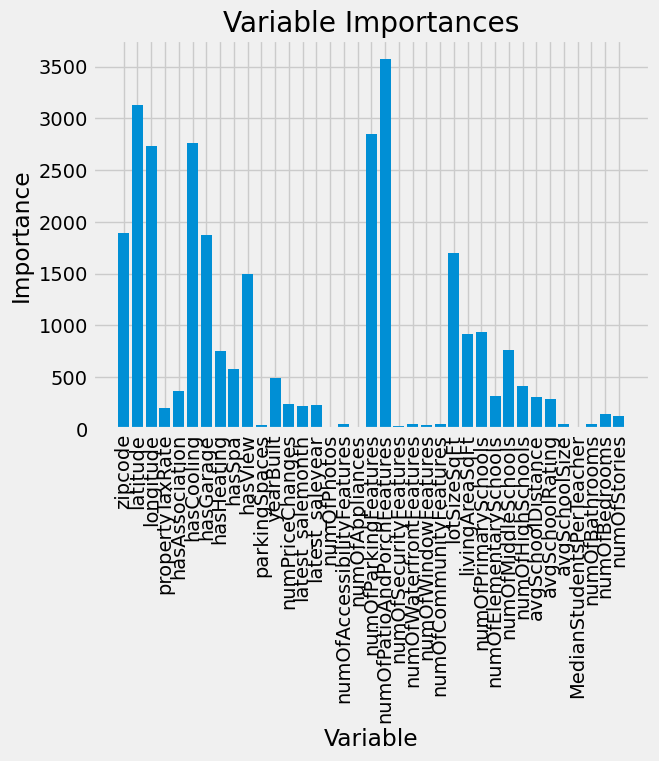

In [59]:
importances= model_light_final.feature_importances_
feature_list = data_train.drop(columns = "latestPrice").columns

%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

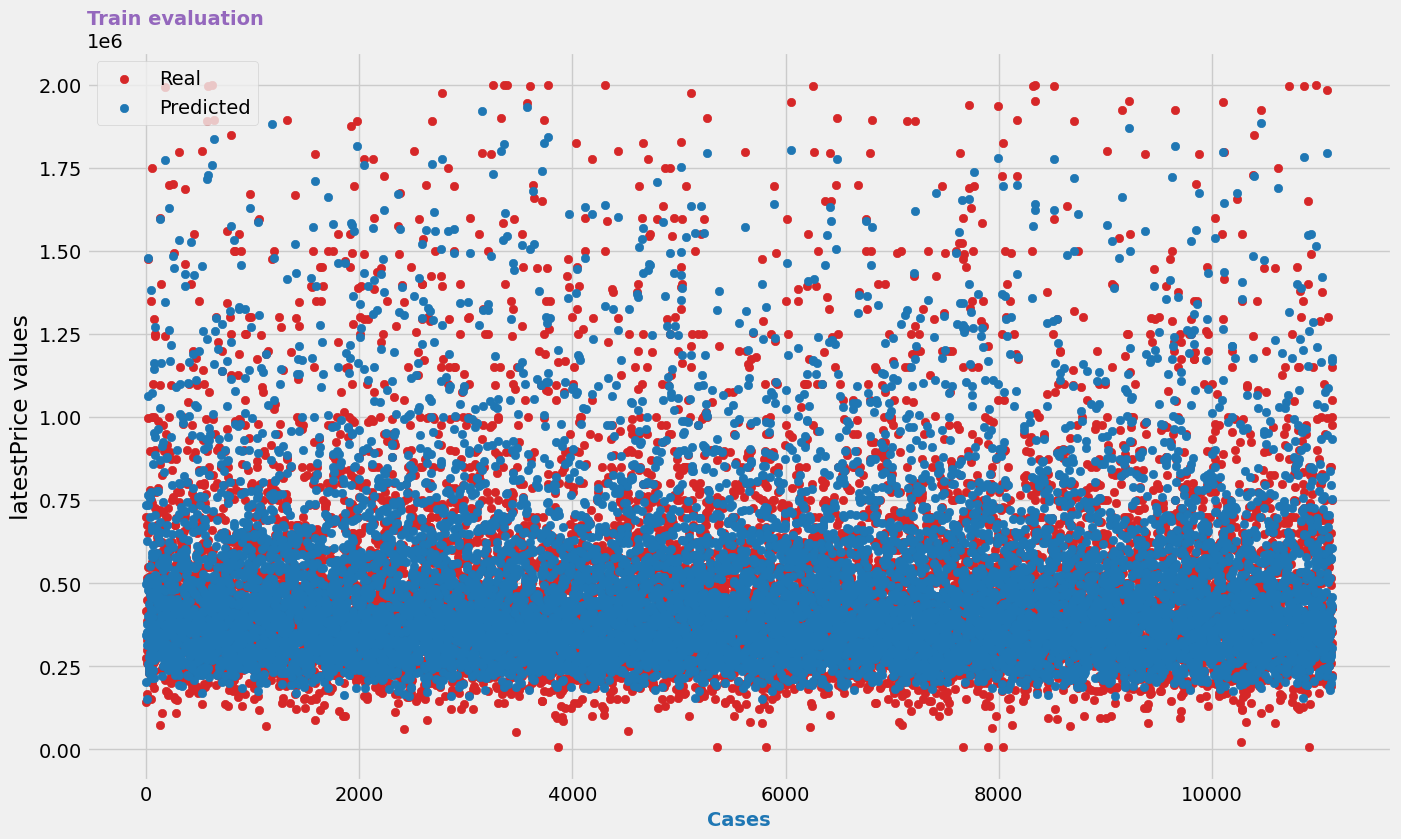

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_train)))

ax.scatter(x_axis, y_train, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

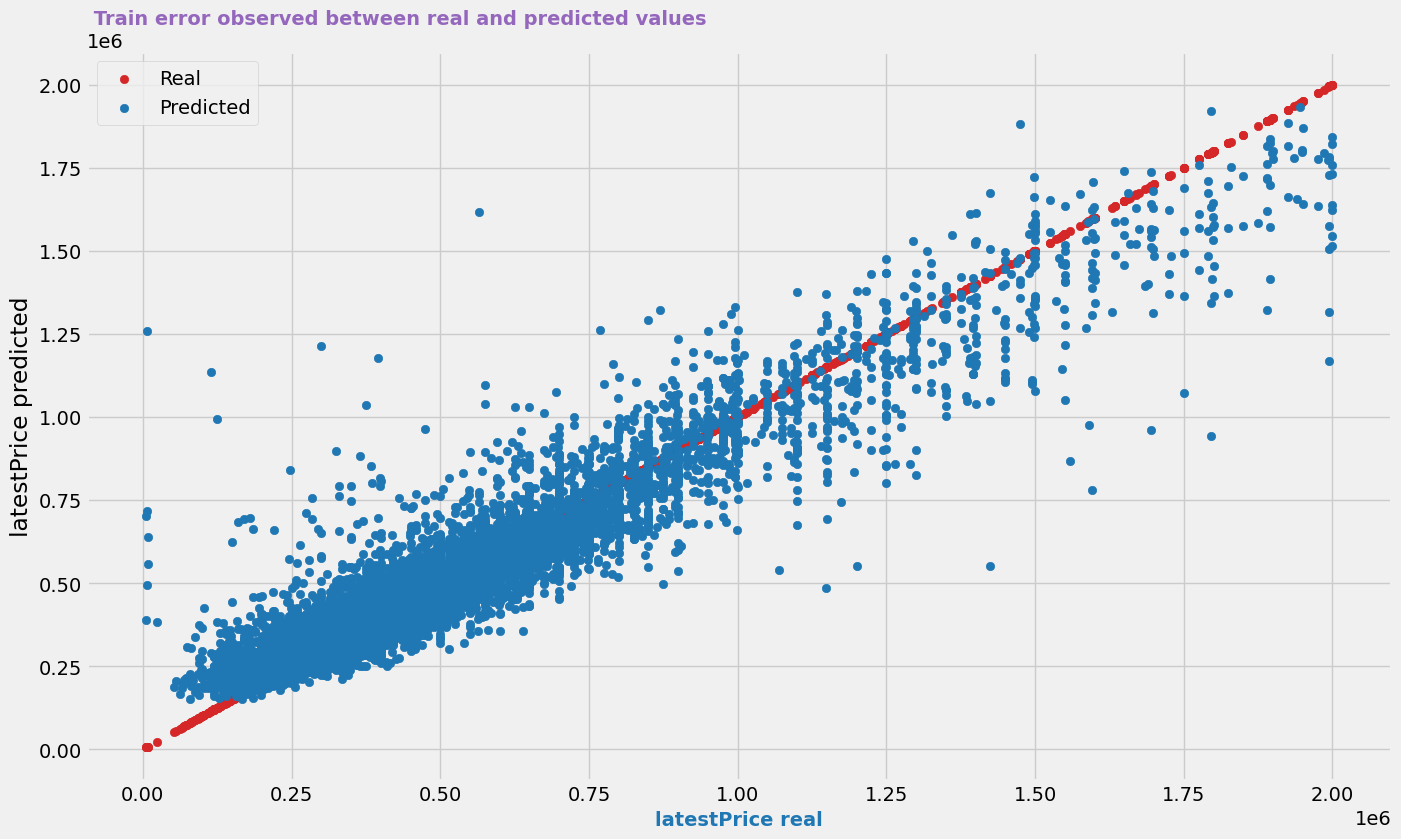

In [61]:
#######  TRAIN

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_train, y_train, color = 'tab:red', label='Real')
ax.scatter(y_train, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice real", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice predicted")
ax.set_title(' Train error observed between real and predicted values', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

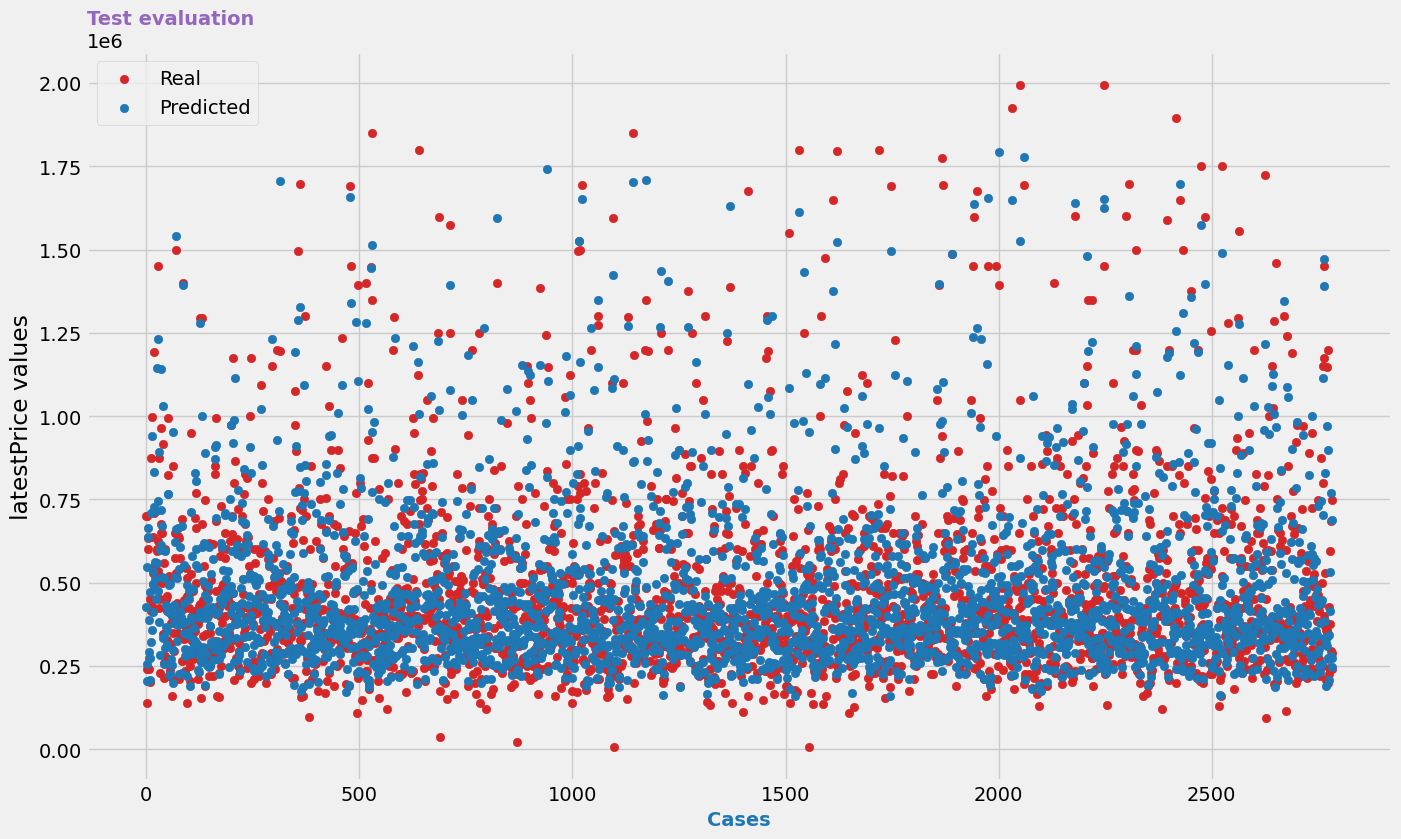

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_test)))

ax.scatter(x_axis, y_test, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

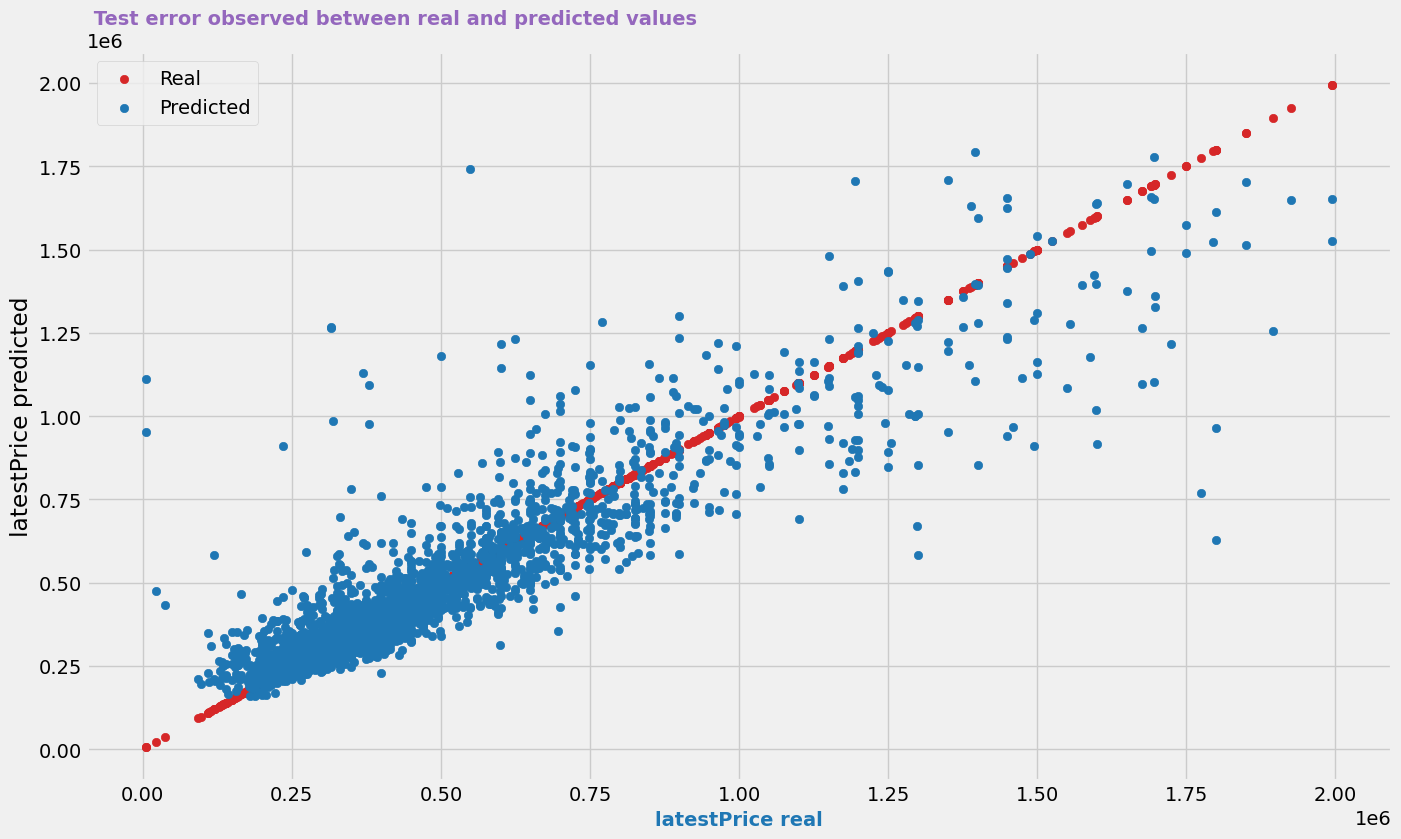

In [63]:
#######  TEST

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_test, y_test, color = 'tab:red', label='Real')
ax.scatter(y_test, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice real", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice predicted")
ax.set_title(' Test error observed between real and predicted values', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()